# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import neuro_op as nop
import matplotlib.pyplot as plt
# import networkx as nx
import numpy as np
import scipy.stats as st

In [2]:
nodes, G, beliefs, world, N_events, t_end, kl_divs_means, t_sample, RANDOM_SEED = nop.run_model(
    N_nodes=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(500),
    likelihood=st.norm(loc=0, scale=5),
    world_dist=st.norm(loc=0, scale=5),
    h=1,
    r=1,
    t0=0,
    t_max=10000,
    t_sample=100,
    sample_bins=50,
    sample_opinion_range=[-20, 20],
)

print(f"Number of events: {N_events}")


Sampling at t= 0
Sampling at t= 100.14463615740083


/home/jens/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:223: RuntimeWarning: invalid value encountered in divide
  ppd_world_out = ppd_world_out[0] / np.sum(
/home/jens/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:135: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jens/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:135: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


Sampling at t= 200.83822339929574
Sampling at t= 300.9723000028802
Sampling at t= 400.9348089413629
Sampling at t= 500.2122545626009
Sampling at t= 600.051413232253
Sampling at t= 700.1177561636588
Sampling at t= 800.52539623052
Sampling at t= 901.4882917540742
Sampling at t= 1000.0705157670917
Sampling at t= 1100.037757160313
Sampling at t= 1200.3867731919654
Sampling at t= 1300.0394914408182
Sampling at t= 1400.0302454145487
Sampling at t= 1500.3162793780639
Sampling at t= 1600.5151108126067
Sampling at t= 1700.9907760670374
Sampling at t= 1800.1152100827526
Sampling at t= 1900.451675006549
Sampling at t= 2000.6988926038482
Sampling at t= 2100.132232356493
Sampling at t= 2200.214815622946
Sampling at t= 2300.3794521663735
Sampling at t= 2400.096426836989
Sampling at t= 2501.7191085228465
Sampling at t= 2600.1502279557753
Sampling at t= 2701.1256697309145
Sampling at t= 2800.01607706613
Sampling at t= 2900.3237591562693
Sampling at t= 3000.3331114877597
Sampling at t= 3100.10204344896

## Data analysis

After simulating the network with $h=1, r=0$ (meaning nodes communicating with the central node only), some simple analysis steps follow.



In [3]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


Text(0, 0.5, '$p(\\mu|x_i)$')

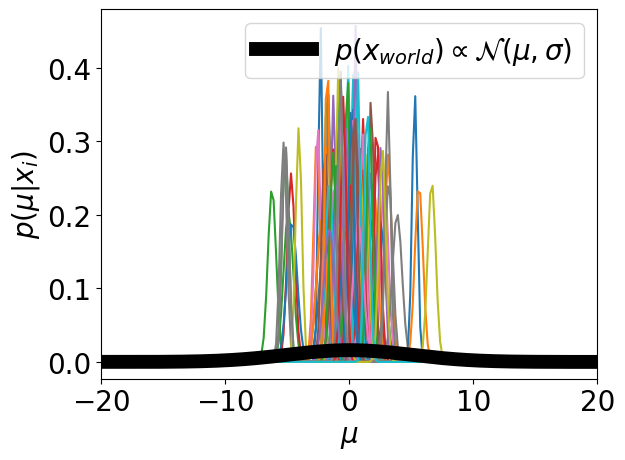

In [4]:
for i in range(len(nodes)):
    plt.plot(nodes[0].beliefs, nop.logpdf_to_pdf(nodes[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(
    beliefs,
    nop.logpdf_to_pdf(world.log_probs),
    color="black",
    linewidth=10,
    label="$p(x_{world}) \propto \mathcal{N}(\mu,\sigma)$",
)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu|x_i)$")

#### Data analysis 2

Each node executes posterior predictive distribution sampling to generate a forecast of expected future data.

For some eye-balling analysis, histograms of `world_dist`'s and some nodes' PPD samples are plotted.

In [5]:
# Define parameters of data analysis
N_bins = 50  # go for uneven bin number to have a bin centered on 0
opinion_range = [-20, 20]  # chosen by experience, no formal reasoning

# Generate posterior predictive distributions (PPDs) for each node by generating ppd samples and binning them into histograms
ppd_samples = [
    nop.ppd_Gaussian_mu(node.beliefs, node.log_probs, 10000) for node in nodes
    ]
ppds = [  # PPD stored as histograms. Each histogram is a tuple (counts, bin_edges).
    np.histogram(
        i,
        bins=N_bins,
        range=opinion_range,
    )
    for i in ppd_samples
]

ppd_world = np.histogram(
    world.diary_out,
    bins=N_bins,
    range=opinion_range,
)

world_binned = nop.dist_binning(world.likelihood, N_bins, opinion_range)

# Save the centre of each node's bin with most samples.
# We then assume 'centres of each node's bin with most samples' == 'maximum likelihood estimates (MLEs) of each node')
argmax = np.argmax(ppd_world[0])
mu_world = (ppd_world[1][argmax] + ppd_world[1][argmax + 1]) / 2

argmax = [np.argmax(ppds_hist[0]) for ppds_hist in ppds]
mu_nodes = [
    (hist_data[1][i] + hist_data[1][i + 1]) / 2 for hist_data, i in zip(ppds, argmax)
]

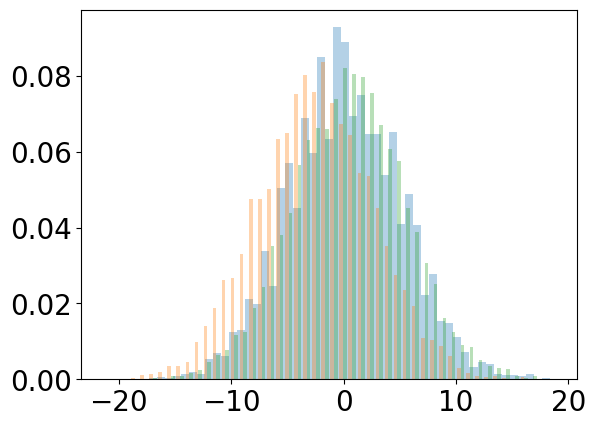

In [6]:
for i in [world.diary_out, ppd_samples[:2]]:
    plt.hist(i, bins=N_bins, density=True, alpha=1/3)

Mean KL divergence:	 0.10230491667390684
Mean linear p-distance:	 1.7359999999999998
Mean quad. p-distance:	 5.2928


(array([58., 15.,  6.,  5.,  4.,  0.,  0.,  2.,  0.,  1.,  2.,  0.,  2.,
         2.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([0.00213353, 0.04381969, 0.08550585, 0.12719201, 0.16887817,
        0.21056432, 0.25225048, 0.29393664, 0.3356228 , 0.37730896,
        0.41899511, 0.46068127, 0.50236743, 0.54405359, 0.58573975,
        0.6274259 , 0.66911206, 0.71079822, 0.75248438, 0.79417054,
        0.83585669]),
 <BarContainer object of 20 artists>)

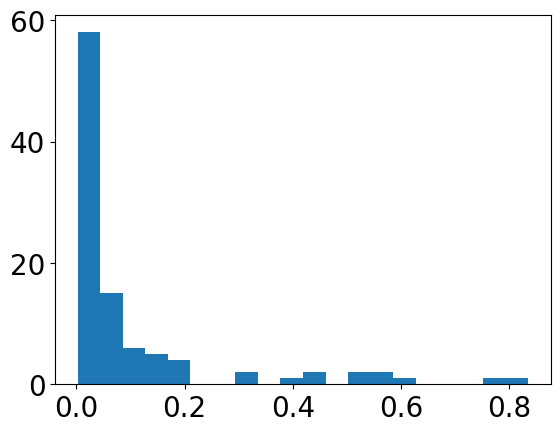

In [7]:
kl_divs = []
for i in ppds:
    P_sampled = i[0] / np.sum(i[0])
    kl_divs.append(nop.kl_divergence(P_sampled, world_binned))

print(f"Mean KL divergence:\t {np.mean(kl_divs)}")
print(f"Mean linear p-distance:\t {nop.p_distances(mu_nodes, mu_world, p=1)/len(nodes)}")
print(f"Mean quad. p-distance:\t {nop.p_distances(mu_nodes, mu_world, p=2)/len(nodes)}")
plt.hist(kl_divs, bins=20)


[[        nan  1.58314235]
 [18.32564347  2.25929536]
 [ 9.60570475  1.43662677]
 [ 6.05430071  1.08817592]
 [ 4.64541674  0.81933651]
 [ 3.99922925  0.70010589]
 [ 3.45701862  0.61615393]
 [ 3.13648754  0.56034666]
 [ 2.6912119   0.51513099]
 [ 2.20581579  0.46653808]
 [ 1.88717386  0.43665899]
 [ 1.77484466  0.40977357]
 [ 1.66697814  0.3921643 ]
 [ 1.63893888  0.38093146]
 [ 1.55546062  0.36404813]
 [ 1.47178297  0.35186517]
 [ 1.43876185  0.33199558]
 [ 1.38242379  0.31853451]
 [ 1.28998014  0.30865773]
 [ 1.14785104  0.30070653]
 [ 0.88410302  0.29048893]
 [ 0.85684809  0.27862272]
 [ 0.82738481  0.27454198]
 [ 0.84111752  0.26913129]
 [ 0.79595474  0.26277633]
 [ 0.70609594  0.25703708]
 [ 0.67750957  0.24767387]
 [ 0.66802924  0.24481688]
 [ 0.55385236  0.23978374]
 [ 0.5447249   0.23546676]
 [ 0.52360391  0.23065914]
 [ 0.51126053  0.22460615]
 [ 0.51141488  0.2212905 ]
 [ 0.50107687  0.22036871]
 [ 0.49920452  0.21628266]
 [ 0.49984494  0.21484908]
 [ 0.47274247  0.20684037]
 

Text(0, 0.5, '$KLD(P,Q)$')

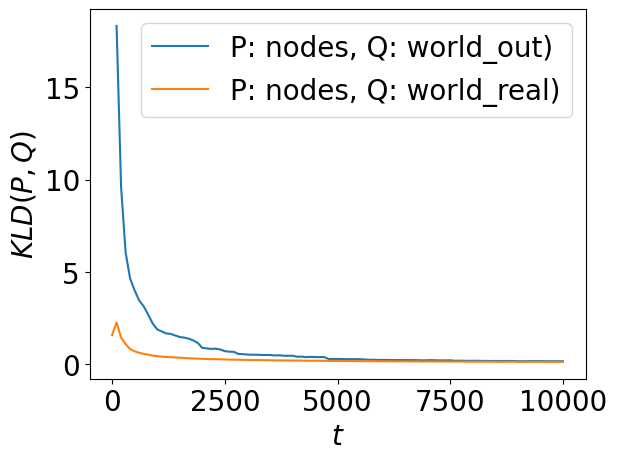

In [8]:
kl_divs_means = np.array(kl_divs_means)
print(kl_divs_means)

plt.plot(range(0, int(t_end+1), t_sample), kl_divs_means[:,0],
    label="P: nodes, Q: world_out)"
)
plt.plot(range(0, int(t_end+1), t_sample), kl_divs_means[:,1],
    label="P: nodes, Q: world_real)"
)
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$KLD(P,Q)$")